# Compute the Mean Square Displacement (MSD)

In [1]:
import sys
import timeit
import h5py
import numpy as np
import scipy as sp
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
from ipywidgets import interact
import pythonpackage.computation
from pythonpackage.computation import compute_msd, compute_msd_notoptimized
import pythonpackage.plot
from pythonpackage.plot import plot_msd, plot_coordinates
from notebookstyle import css_styling
%matplotlib inline
css_styling()

### Packages versions

In [2]:
print("Python version: {}".format(sys.version))
print("NumPy version: {}".format(np.__version__))
print("Scipy version: {}".format(sp.__version__))
print("h5py version: {}".format(h5py.__version__))
print("Matplotlib version: {}".format(mpl.__version__))
print("computation module version: {}".format(pythonpackage.computation.__version__))
print("plot module version: {}".format(pythonpackage.plot.__version__))

Python version: 3.6.2 |Intel Corporation| (default, Aug 15 2017, 17:12:56) 
[GCC 4.2.1 Compatible Apple LLVM 7.3.0 (clang-703.0.31)]
NumPy version: 1.13.1
Scipy version: 0.19.1
h5py version: 2.7.0
Matplotlib version: 2.0.2
computation module version: 0.1.0
plot module version: 0.1.0


## Read data

A 100ps molecular dynamics simulation (microcanonical (NVE) ensemble) of 256 water molecules (SPCE model).

In [3]:
file = 'Trajectories/spce300K_NVE_reduced.h5'

Explore the NetCDF file

In [4]:
with h5py.File(file, 'r') as f:
    ds = list(f.keys())
ds

['box_size', 'coordinates', 'natoms', 'time']

Extract the datasets

In [5]:
with h5py.File(file, 'r') as f:
    time = np.copy(f['time'])
    box_size = np.copy(f['box_size'])
    coordinates = np.copy(f['coordinates'])
    natoms = np.copy(f['natoms'])

In [6]:
print(f"There are {natoms[0]} atoms and {time.shape[0]} steps.")
print(f"""The shape of the the coordinates array is: {coordinates.shape}. 
      The first dimension represents the steps, 
      the second dimension corresponds to the atoms and 
      the third dimension corresponds to the cartesian coordinates.""")

There are 768 atoms and 10001 steps.
The shape of the the coordinates array is: (10001, 768, 3). 
      The first dimension represents the steps, 
      the second dimension corresponds to the atoms and 
      the third dimension corresponds to the cartesian coordinates.


## Remove PBC (Periodic Boundary Conditions)

In [7]:
box_size = np.unique(box_size[:])

In [8]:
dr = coordinates[1:, :, :] - coordinates[:-1, :, :]

In [9]:
# correction - remove PBC
dr[dr>box_size/2] -= box_size
dr[dr<-box_size/2] += box_size

In [10]:
# apply correction to the first coordinate (t0)
coord_nopbc = np.concatenate((np.array([coordinates[0, :, :]]), np.array(coordinates[0, :, :]) + dr.cumsum(axis=0)))

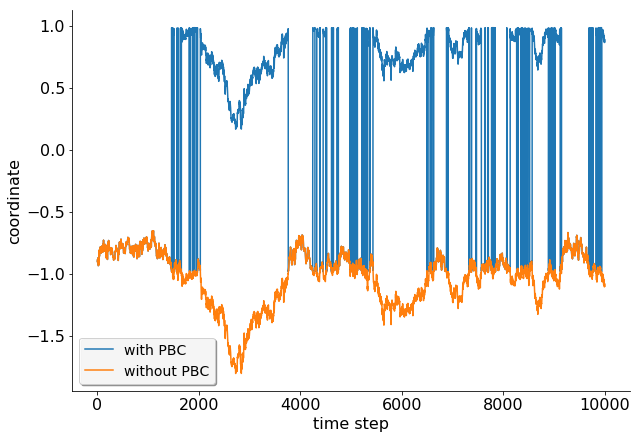

In [11]:
plot_coordinates(coordinates[:, 0, 0], coord_nopbc[:, 0, 0])

## Compute MSD for 2 atoms

Comparing the straightforward implementation (compute_msd_notoptimized()) and the implementation proposed in this [paper](http://dx.doi.org/10.1051/sfn/201112010) (http://dx.doi.org/10.1051/sfn/201112010 - compute_msd()):

In [12]:
t_noopt = %timeit -o compute_msd_notoptimized(coord_nopbc[:,0,:])

5.48 s ± 137 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
t_opt = %timeit -o compute_msd(coord_nopbc[:,0,:])

7.06 ms ± 1.93 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
print(f"The optimized implementation is ~{int(t_noopt.average//t_opt.average):d} faster.")

The optimized implementation is ~775 faster.


In [15]:
msd_0 = compute_msd(coord_nopbc[:,0,:])

In [16]:
msd_9 = compute_msd(coord_nopbc[:,9,:])

Plot the 2 MSD

You can change the percentage between 0 and 1.0 (percentage of the data that will be plotted)

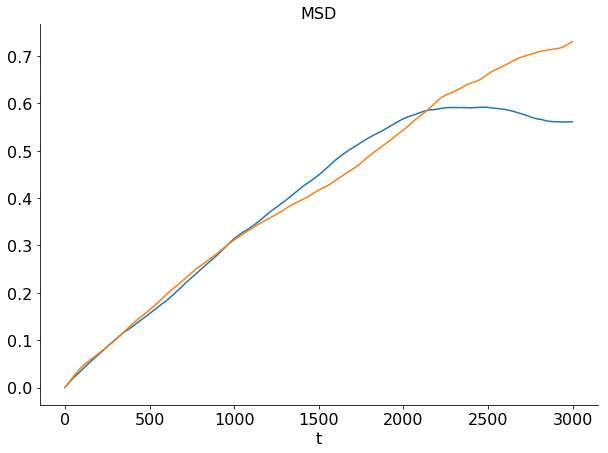

In [17]:
plot_msd(msd_0, msd_9, percentage=0.3)

## MSD for oxygen and hydrogen atoms

Compute MSD for all atoms

In [18]:
msd = np.array([compute_msd(coord_nopbc[:,i,:]) for i in range(natoms[0])])

MSD for oxygen atoms

In [19]:
msd_O = msd[0::3]

MSD for hydrogen atoms

In [20]:
msd_H1 = msd[1::3]
msd_H2 = msd[2::3]

Average MSD for oxygen and hydrogen atoms

In [21]:
msd_O_av = msd_O.sum(axis=0) / len(msd_O)

In [22]:
msd_H_av = (msd_H1+msd_H2).sum(axis=0) / (2*len(msd_H1))

Plot

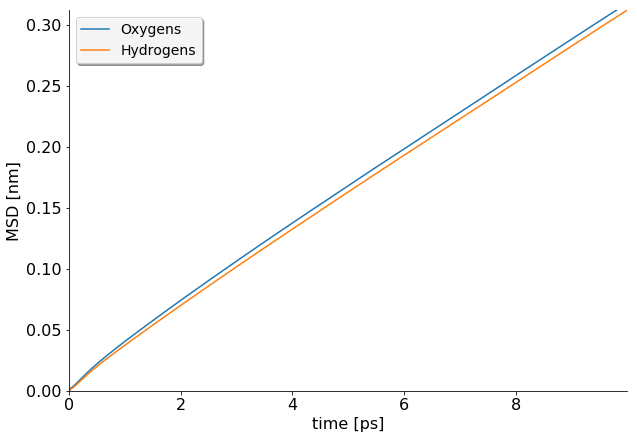

In [23]:
plot_msd(np.vstack((time, msd_O_av)), np.vstack((time, msd_H_av)), percentage=0.1, legend=['Oxygens', 'Hydrogens'])

## Fit MSD

##### Oxygen atoms

In [24]:
fit = np.polyfit(time[:1000], msd_O_av[:1000], deg=1)

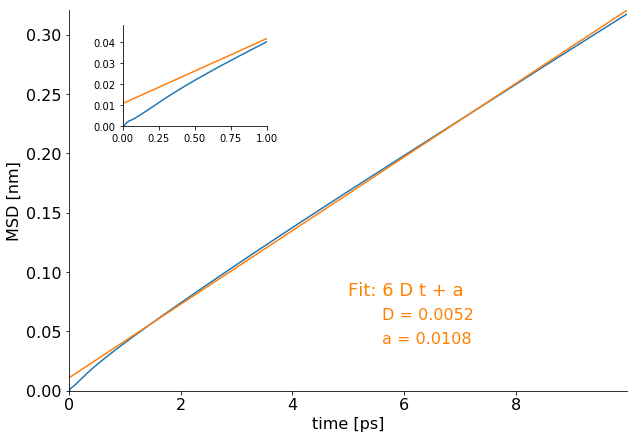

In [25]:
#plot msd for oxygen atoms and fit
plot_msd(np.vstack((time, msd_O_av)), np.vstack((time, fit[0]*time+fit[1])), 
         percentage=0.1, fit=(fit[0], fit[1]))

Rajouter text pour les paramètres du fit et faire pour les atomes d'hydrogènes

##### Hydrogen atoms

In [26]:
fit = np.polyfit(time[:1000], msd_H_av[:1000], deg=1)

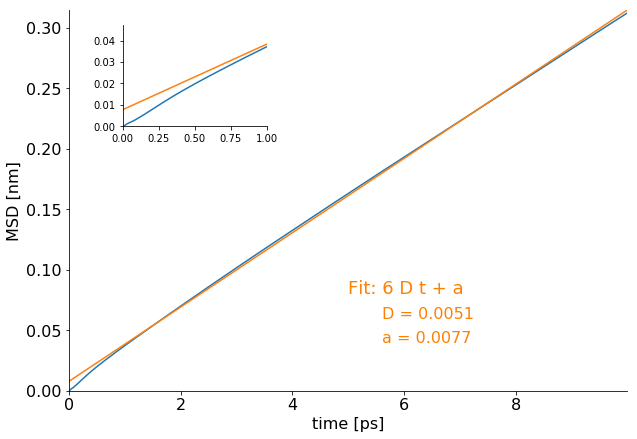

In [27]:
#plot msd for oxygen atoms and fit
plot_msd(np.vstack((time, msd_H_av)), np.vstack((time, fit[0]*time+fit[1])), 
         percentage=0.1, fit=(fit[0], fit[1]))